In [42]:
from __future__ import division
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline


In [43]:
churn_df = pd.read_csv('../data/churn.csv')
col_names = churn_df.columns.tolist()

print("Columns Names:")
print(col_names)

to_show = col_names[:6] + col_names[-6:]
print("\n Sample Data")
churn_df[to_show].head()

Columns Names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

 Sample Data


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.


In [44]:
# Isolate target variable 
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.' , 1,0)

In [45]:
#Drop few not required columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [46]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan" , "VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == "yes"

In [47]:
# Pull out feature space for future use 
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [48]:
X = churn_feat_space.as_matrix().astype(np.float)
# Standard Scalar
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. StandardScaler fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

Great, I now have a feature space X and a set of target values y. On to the predictions!

In [68]:
from sklearn.model_selection import KFold
def run_cv(X , y , clf_class , **kwargs):
    # construct KFold object
    kf = KFold(n_splits = 3 , shuffle= True)
    y_pred = y.copy()
    #print(kf)
    #iterate through folds 
    for train_index , test_index in kf.split(X):
        #print(train_index , test_index)
        X_train , X_test = X[train_index] , X[test_index]
        y_train = y[train_index]
        # intialize classifier with key word arguments 
        clf = clf_class(**kwargs)
        clf.fit(X_train , y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Let's compare three fairly unique algorithms support vector machines, random forest, and k-nearest-neighbors. Just passing each to cross validation and determining how often the classifier predicted the correct class.

In [71]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR))) 
print("Gradient Boosting Classifier") 
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print("Support vector machines:") 
print("%.3f" % accuracy(y, run_cv(X,y,SVC))) 
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN))) 

Logistic Regression:
0.862
Gradient Boosting Classifier
0.948
Support vector machines:
0.917
Random forest:
0.944
K-nearest-neighbors:
0.893


# Precision and Recall

[[2821   29]
 [ 250  233]]


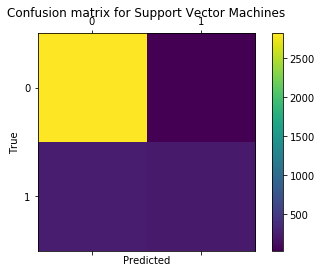

[[2822   28]
 [ 158  325]]


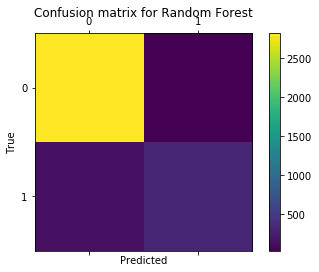

[[2806   44]
 [ 322  161]]


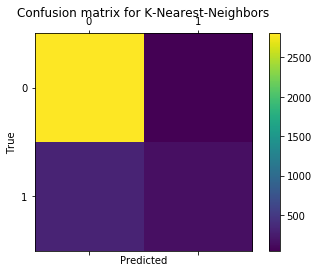

[[2809   41]
 [ 124  359]]


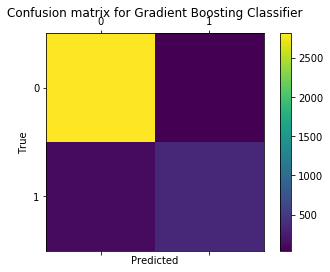

[[2777   73]
 [ 387   96]]


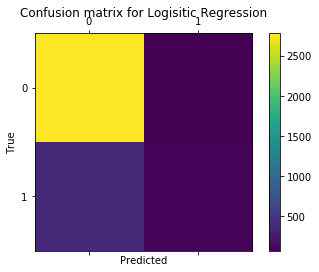

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

# ROC Plots & AUC

Support vector machines:


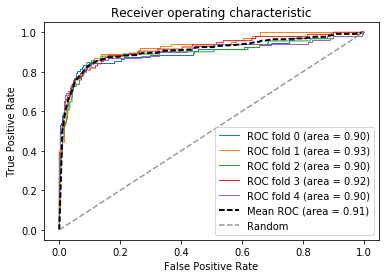

Random forests:


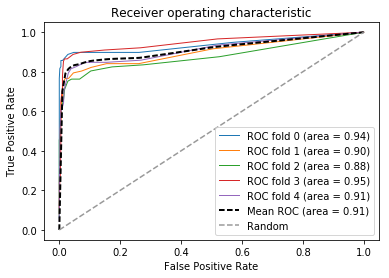

K-nearest-neighbors:


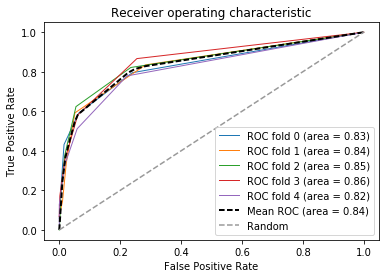

Gradient Boosting Classifier:


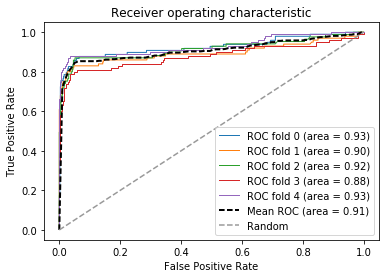

In [81]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(n_splits= 5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        #print(len(kf.split(X)))
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= kf.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

print("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print("Random forests:") 
plot_roc(X,y,RF,n_estimators=18)

print("K-nearest-neighbors:") 
plot_roc(X,y,KNN)

print("Gradient Boosting Classifier:") 
plot_roc(X,y,GBC)

Feature ranking:
1. Account Length (0.168443)
2. Int'l Plan (0.129557)
3. VMail Plan (0.071928)
4. VMail Message (0.066200)
5. Day Mins (0.062325)
6. Day Calls (0.034097)
7. Day Charge (0.031764)
8. Eve Mins (0.028497)
9. Eve Calls (0.028158)
10. Eve Charge (0.014317)


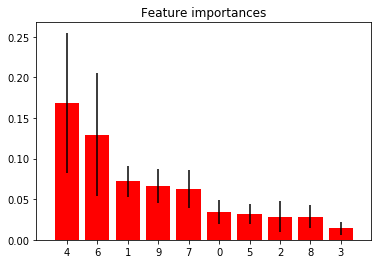

In [82]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

In [84]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [85]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1820
0.1     649
0.2     276
0.3      99
0.9      82
0.8      80
0.6      70
0.7      70
0.4      66
0.5      62
1.0      59
dtype: int64

In [86]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1820,0.030769
1,0.1,649,0.024653
2,0.2,276,0.043478
3,0.3,99,0.171717
4,0.4,66,0.257576
5,0.5,62,0.564516
6,0.6,70,0.857143
7,0.7,70,0.771429
8,0.8,80,0.937500
9,0.9,82,1.000000


In [91]:
from churn_measurements import calibration, discrimination
from sklearn.metrics import roc_curve, auc
from scipy import interp
from __future__ import division 
from operator import truediv


      
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print("  %-20s %.4f" % ("Calibration Error", calibration(churn_prob, is_churn))) 
    print("  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,is_churn))) 

    print("Note -- Lower calibration is better, higher discrimination is better") 

In [92]:

print("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print("Random forests:")
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print("K-nearest-neighbors:")
print_measurements(run_prob_cv(X,y,KNN))

print("Gradient Boosting Classifier:")
print_measurements(run_prob_cv(X,y,GBC))

print("Random Forest:") 
print_measurements(run_prob_cv(X,y,RF))

Support vector machines:
  Calibration Error    0.0011
  Discrimination       0.0678
Note -- Lower calibration is better, higher discrimination is better
Random forests:
  Calibration Error    0.0066
  Discrimination       0.0845
Note -- Lower calibration is better, higher discrimination is better
K-nearest-neighbors:
  Calibration Error    0.0032
  Discrimination       0.0462
Note -- Lower calibration is better, higher discrimination is better
Gradient Boosting Classifier:
  Calibration Error    0.0026
  Discrimination       0.0838
Note -- Lower calibration is better, higher discrimination is better
Random Forest:
  Calibration Error    0.0073
  Discrimination       0.0791
Note -- Lower calibration is better, higher discrimination is better
